# Perceptron Multicapa para una regresión lineal

En este ejercicio vamos a crear una red para pronosticar el consumo de gasolina de los coches. Los datos provienen de la universidad de California y son ampliamente utilizados en los curos de Deep Learning.

La información de los datos la tienes en este enlace, y son un conjunto de datos que contiene las siguientes variables:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

El objetivo es pronosticar mpg que es el consumo de gasolina de los coches (millas por galón) basándose en las otras variables.

La variable origin esta compuesta por tres valores:

- 1: USA
- 2: Europe
- 3: Japan


Así que lo mejor es hacer un one hot con ella.

Como la variable MPG es continua vamos a utilizar un capa final lineal y como función de pérdida el mse.

Además vamos a separar el conjunto de datos en tres: train, dev y test como se ha visto en la teoría y haremos unos gráficos para ver la evolución del aprendizaje y el ajuste final.



In [14]:
# paquetes y librerías que vamos a necesitar

import tensorflow as tf

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

import time


2.15.0


In [15]:
# funciones que nos van a ayudar

# normaliza un conjunto de datos
def norm(x, st):
    return((x - st['mean'])/st['std'])

# un plot de la historia del ajuste
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mse'],'b',
           label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show() # un €



In [16]:
# Cargamos los datos
# Keras nos permite cargar directamente un fichero que este en internet 

# Especificamos la direccion donde esta el fichero y su nombre y como lo queremos guardar
dataset_path = tf.keras.utils.get_file("auto-mpg.data",
                                       "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

# El csv viene sin ninguna cabezera estos son los nombres de las variables
column_names = ['MPG', 'Cylinders','Displacement','Horsepower','Weight','Acceleration','Model year','Origin']

# se lee el fichero
data = pd.read_csv(dataset_path, names=column_names, na_values="?",
                          comment='\t', sep=" ", skipinitialspace=True)

In [4]:
# vemos las primeras filas de los datos
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [17]:
# PREPROCESAMIENTO --------------------

# El fichero tiene datos perdidos y hay que eliminar las filas donde estan
data = data.dropna() 



# La variable origin viene codificada de forma numerica pero la pasamos a un one hot

# no te preocupes por este codigo, cosas de python
o = data.pop('Origin')
data['USA'] = (o == 1)*1.0
data['Europe'] = (o == 2)*2.0
data['Japan'] = (o == 3)*3.0

# comprobamos que ahora tenemos una variable para cada pais de origen
data.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


In [18]:
# Como el train y test sets no estan creados los creamos ahora aleatoriamente

x_train = data.sample(frac=0.8, random_state=0)
x_test = data.drop(x_train.index)

y_train = x_train.pop('MPG')
y_test = x_test.pop('MPG')


In [7]:
x_train.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,3.0


In [8]:
y_train.head()

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64

Si quieres investiga un poco el código anterior para aprender un poco de python o si prefieres déjalo como está. Lo que hemos hecho es:
1. x_train se crea eligiendo aleatoriamente el 80% de las filas de data
1. x_test son simplemente las que no han sido elegidas
1. y_train e y_test son solo la variable MPG de los conjuntos de datos anteriores


In [9]:
# como vemos las variables en x tienen valores muy dispares, vamos a normalizarlas
# para que funcione adecuadamente el optimizador y no haya problemas de
# exploding gradient

# No es necesario normalizar y porque es la que intentamos predecir y queremos ver
# cuanto nos estamos equivocando en la escala real

In [19]:
# calculamos los estadisticos descriptivos para x_train
x_train_stats = x_train.describe().transpose()
x_train_stats.head()

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8


In [20]:
# calculamos los estadisticos descriptivos para x_test
x_test_stats = x_test.describe().transpose()
x_test_stats.head()

,count,mean,std,min,25%,50%,75%,max
Cylinders,78.0,5.448718,1.740633,3.0,4.00,4.00,8.00,8.0
Displacement,78.0,190.762821,106.494733,70.0,98.00,138.00,292.00,400.0
Horsepower,78.0,102.858974,40.255265,48.0,74.25,90.00,121.75,230.0
Weight,78.0,2926.589744,874.900416,1613.0,2159.50,2692.50,3706.50,4746.0
Acceleration,78.0,15.469231,2.649298,8.5,13.70,15.25,17.00,22.2


In [21]:
# normalizamos x_train y x_test

x_train_norm = norm(x_train, x_train_stats)
x_train_norm.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


In [22]:
x_test_norm = norm(x_test, x_test_stats)
x_test_norm.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
9,1.465721,1.870864,2.164711,1.055446,-2.630595,-1.694775,0.764362,-0.423659,-0.524515
25,1.465721,1.589160,2.785748,1.929831,-0.554574,-1.694775,0.764362,-0.423659,-0.524515
28,1.465721,1.063312,2.239236,2.063561,1.143989,-1.694775,0.764362,-0.423659,-0.524515
31,-0.832294,-0.730203,-0.195228,-0.798479,-0.554574,-1.426091,-1.291508,-0.423659,1.882082
33,0.316714,0.387223,-0.071021,-0.334426,-0.932032,-1.426091,0.764362,-0.423659,-0.524515


In [23]:
# comprobamos que lo hemos hecho bien

x_train_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,1.824443e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,8.627211e-17,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-9.900078e-18,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-8.485781e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,-5.148041e-16,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model year,314.0,9.772791e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,7.920062e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,1.980016e-17,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,-2.262875e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


Está perfecto, las medias cercanas a cero (2.093159e-16) y las sd en 1.0

In [49]:
# Modelo --------------------------


# Configuramos la topología

model = Sequential()
model.add(Dense(10, activation = 'relu', input_shape=[( len(x_train_norm.keys()) )]))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                100       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 111 (444.00 Byte)
Trainable params: 111 (444.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# compilamos

model.compile(loss='mse',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.003),
              metrics = ['mse','mae'])

In [51]:
# entrenamos
start = time.time()
history = model.fit(x_train_norm, y_train,
                    epochs = 300,
                    validation_split = 0.2,  # divide automaticamente el train
                                             # en train (80%) y dev (20%)
                    verbose = 0) # para evitar que se llene toda la pantalla

end = time.time()
print('Tiempo de ejecución:', end - start)

Tiempo de ejecución: 13.585203409194946


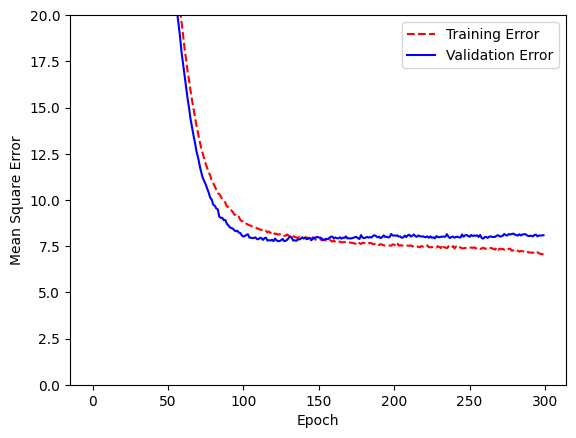

In [52]:
# Un grafico para ver el ajuste en los dos sets

plot_history(history)

In [53]:
# Evaluamos el modelo con el conjunto de validacion
model.evaluate(x_test_norm, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 6.2696 - mse: 6.2696 - mae: 1.8045


[6.269641876220703, 6.269641876220703, 1.8044662475585938]

3/3 [==============================] - 0s 0s/step


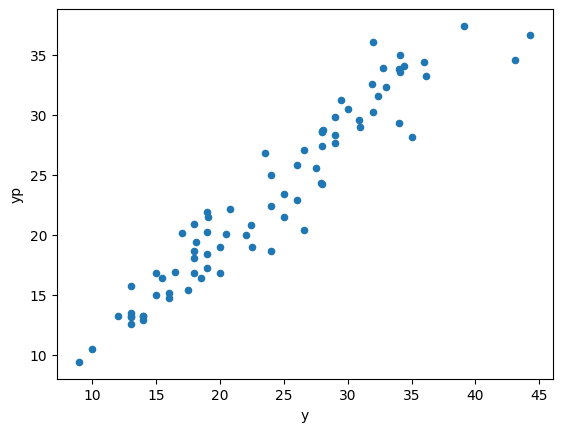

R² del modelo: 0.9040


In [54]:
# Como las variables son cuantitativas un grafico de dispersion podría estar perfecto

yp = model.predict(x_test_norm)


df = pd.DataFrame({'y': y_test, 'yp': yp.flatten()})
df.plot.scatter(x='y', y='yp')
plt.show()



r2 = r2_score(df['y'], df['yp'])
print(f"R² del modelo: {r2:.4f}")

# Ejercicio

Prueba a modificar los hiperparámetros de la red e incluso su arquitectura para obtener una mayor velocidad en la red. Por ejemplo podrías hacer lo siguiente:

1. Prueba a utilizar otros tipos de neuronas (RelU o tanh) y otros optimizadores para mejorar el tiempo de aprendizaje
1. Simplifica al máximo la red pero sin una pérdida significativa de predicción

--- 

Haz las pruebas que consideres interesantes e interpreta los resultados.

Pega el código empleado (solo las partes que has cambiado) en la ventana de abajo

Para ayudarte en las tareas simplemente usa google, te aportará miles de ejemplos

Recuerda que los resultados tienes que subirlos a un cuestionario de moodle

---

__Opcional__: aprovechando que tenemos en df los valores de y_test y de yp (los pronosticados) calcula el R2 de esta recta que nos indicará la calidad del pronóstico usando un lenguaje más estadístico.

### Modificación de las neuronas de activación

#### Usando ReLU



In [ ]:
# Modelo con pocas neuronas en cada capa


model = Sequential()
model.add(Dense(1, activation = 'relu', input_shape=[( len(x_train_norm.keys()) )]))
model.add(Dense(1, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 1)                 10        
                                                                 
 dense_35 (Dense)            (None, 1)                 2         
                                                                 
 dense_36 (Dense)            (None, 1)                 2         
                                                                 
 dense_37 (Dense)            (None, 1)                 2         
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [118]:
# Evaluar el modelo con el conjunto de validación
model.evaluate(x_test_norm, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 8.3851 - mse: 8.3851 - mae: 2.1239


[8.38509464263916, 8.38509464263916, 2.1239407062530518]

3/3 [==============================] - 0s 3ms/step


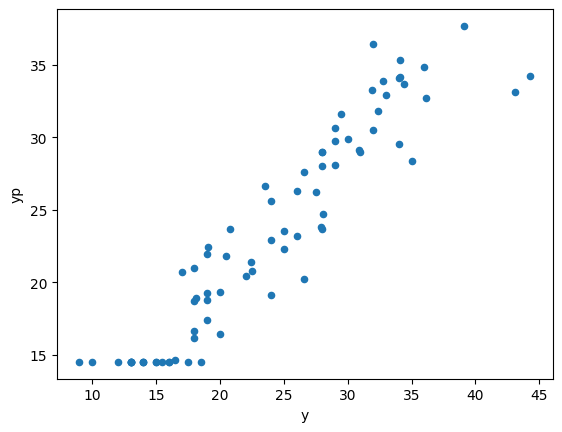

R² del modelo: 0.8716


In [119]:
# Gráfico de dispersión

yp = model.predict(x_test_norm)


df = pd.DataFrame({'y': y_test, 'yp': yp.flatten()})
df.plot.scatter(x='y', y='yp')
plt.show()


# Cálculo del R²

r2 = r2_score(df['y'], df['yp'])
print(f"R² del modelo: {r2:.4f}")

Como se puede observar, usando una cantidad reducida de neuronas (tres capas con 1 neuronas en cada una), con el optimizador RMSprop y 300 épocas, la pérdida entre la muestra de entrenamiento y la de validación es 8.3851 y el R² del modelo es de 0.8716.

In [159]:
# Modelo mejor ajustado


model = Sequential()
model.add(Dense(10, activation = 'relu', input_shape=[( len(x_train_norm.keys()) )]))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 10)                100       
                                                                 
 dense_67 (Dense)            (None, 5)                 55        
                                                                 
 dense_68 (Dense)            (None, 5)                 30        
                                                                 
 dense_69 (Dense)            (None, 1)                 6         
                                                                 
Total params: 191 (764.00 Byte)
Trainable params: 191 (764.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [179]:
# Evaluar el modelo con el conjunto de validación
model.evaluate(x_test_norm, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 5.8864 - mse: 5.8864 - mae: 1.8032


[5.886383533477783, 5.886383533477783, 1.8032453060150146]

3/3 [==============================] - 0s 3ms/step


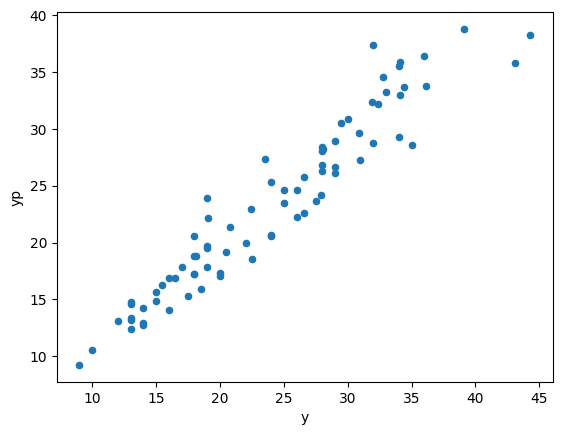

R² del modelo: 0.9099


In [180]:
# Gráfico de dispersión

yp = model.predict(x_test_norm)


df = pd.DataFrame({'y': y_test, 'yp': yp.flatten()})
df.plot.scatter(x='y', y='yp')
plt.show()


# Calculo del R²

r2 = r2_score(df['y'], df['yp'])
print(f"R² del modelo: {r2:.4f}")

En segundo lugar, cabe destacar que el mejor ajuste que hemos conseguido ha sido usando tres capas con 10, 5 y 5 neuronas en cada capa respectivamente; el optimizador RMSprop; y 300 épocas. Como se puede observar, al evaluar el modelo con el conjunto de validación, hemos obtenido una pérdida de 5.8864. Además, el R² del modelo es de 0.9099.

In [ ]:
# Mismas configuraciones, pero usando el optimizador Adam

model.compile(loss='mse',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
              metrics = ['mse','mae'])

In [165]:
# Evaluar el modelo con el conjunto de validacion
model.evaluate(x_test_norm, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 6.0340 - mse: 6.0340 - mae: 1.8590


[6.034012794494629, 6.034012794494629, 1.8590017557144165]

3/3 [==============================] - 0s 2ms/step


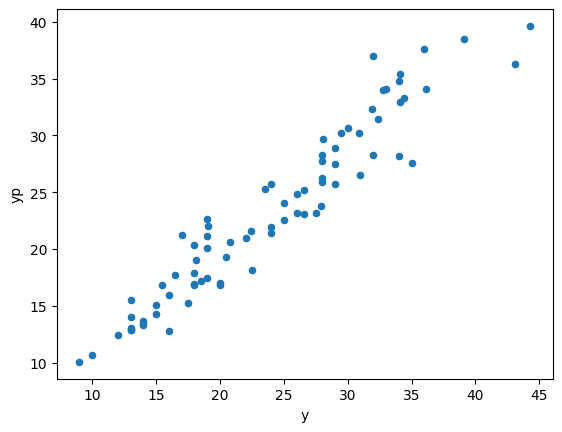

R² del modelo: 0.9076


In [166]:
# Gráfico de dispersión

yp = model.predict(x_test_norm)


df = pd.DataFrame({'y': y_test, 'yp': yp.flatten()})
df.plot.scatter(x='y', y='yp')
plt.show()


# Cálculo del R²

r2 = r2_score(df['y'], df['yp'])
print(f"R² del modelo: {r2:.4f}")

Si en vez de usar el optimizador RMSprop, usamos Adam, se observa como el valor de pérdida aumenta a un  6.0340; y el R² disminuye a 0.9076. No obstante, no es una reducción significativa. 

In [ ]:
# Modelo más simple sin perder capacidad de predicción


model = Sequential()
model.add(Dense(5, activation = 'relu', input_shape=[( len(x_train_norm.keys()) )]))
model.add(Dense(3, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 5)                 50        
                                                                 
 dense_47 (Dense)            (None, 3)                 18        
                                                                 
 dense_48 (Dense)            (None, 2)                 8         
                                                                 
 dense_49 (Dense)            (None, 1)                 3         
                                                                 
Total params: 79 (316.00 Byte)
Trainable params: 79 (316.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
# Evaluar el modelo con el conjunto de validación
model.evaluate(x_test_norm, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 6.4264 - mse: 6.4264 - mae: 1.7685


[6.426403522491455, 6.426403522491455, 1.7685366868972778]

3/3 [==============================] - 0s 3ms/step


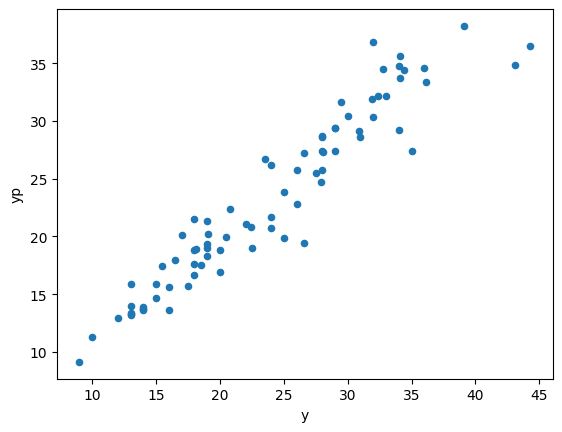

R² del modelo: 0.9016


In [137]:
# Gráfico de dispersión

yp = model.predict(x_test_norm)


df = pd.DataFrame({'y': y_test, 'yp': yp.flatten()})
df.plot.scatter(x='y', y='yp')
plt.show()


# Cálculo del R²

r2 = r2_score(df['y'], df['yp'])
print(f"R² del modelo: {r2:.4f}")

Por último, el modelo más simple que hemos conseguido sin perder capacidad de predicción consta de tres capas con 5, 3 y 2 neronas en cada capa respectivamente. Además, el optimizador que se ha usado ha sido RMSprop y se han estipulado 300 épocas. Como se pude observar, la pérdida del modelo es de 6.4264, y el R² del modelo es 0.9016.